# 1. Loading im.db as pd.df

In [1]:
import pandas as pd
import sqlite3

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline

In [2]:
conn = sqlite3.connect('data/im.db')
cursor = conn.cursor()

imdb_basics = pd.read_sql('''
SELECT *
FROM movie_basics
''', conn)

imdb_akas = pd.read_sql('''
SELECT *
FROM movie_akas
WHERE region = 'US'
GROUP BY movie_id
''', conn)

imdb_ratings = pd.read_sql('''
SELECT *
FROM movie_ratings
''', conn)

# IMDB DF Variable Names
(each DF represents an SQL Table):

- imdb_basics
- imdb_akas
- imdb_ratings

# 3. Merging IMDB

In [3]:
akas_basics_merge = imdb_akas.merge(imdb_basics, on='movie_id',
                                        how='inner')

imdb_merged = akas_basics_merge.merge(imdb_ratings, on='movie_id',
                                       how='left')

# 4. Cleaning tn.movie_budgets for merge

In [4]:
tn_budgets = pd.read_csv('data/tn.movie_budgets.csv.gz')

In [5]:
tn_budgets.drop_duplicates(subset = ['movie'], inplace=True)
tn_budgets.rename(columns = {'movie':'primary_title'}, inplace=True)

In [6]:
#Creating new coumn called year that is date.time
tn_budgets['Release_Date_Time'] = pd.to_datetime(tn_budgets['release_date'])
tn_budgets['start_year'] = tn_budgets['Release_Date_Time'].dt.year

# 5: MERGE Merging Budgets to IMDB

In [7]:
full_movies_df = imdb_merged.merge(tn_budgets, on= ['primary_title','start_year'], how= 'inner')

In [8]:
full_movies_df['Release_Date_Time'] = pd.to_datetime(full_movies_df['release_date'])
full_movies_df['month'] = full_movies_df['Release_Date_Time'].dt.month

In [9]:
full_movies_df['worldwide_gross'] = full_movies_df['worldwide_gross'].str.replace('$','').str.replace(',','').astype(float)
full_movies_df['production_budget'] = full_movies_df['production_budget'].str.replace('$','').str.replace(',','').astype(float)
full_movies_df['domestic_gross'] = full_movies_df['domestic_gross'].str.replace('$','').str.replace(',','').astype(float)

# Analysis:
### Trends in Genre:

In [10]:
#converting dataset to SQL to filter/drop columns easily
full_movies_sql = full_movies_df.to_sql('genres', conn, if_exists='replace', index = False)

#Using tables that are unique and useful
full_movies = pd.read_sql('''
SELECT movie_id, primary_title, genres, start_year, runtime_minutes,
        averagerating, numvotes, production_budget, worldwide_gross
FROM genres 
''', conn)

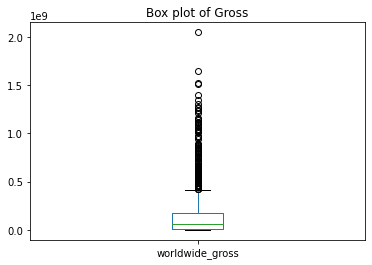

In [11]:
#boxplot of 'worldwide_gross' to find the best measure of central tendency
full_movies["worldwide_gross"].plot(kind="box", title="Box plot of Gross")
plt.show()

#### Splitting genres column to isolate individual genres

In [12]:
# spliting the genres column up so that each movie has an entry for each genre listed

genres = (full_movies.genres.str.split(',', expand=True)
            .stack()
            .to_frame(name='genres'))

genres.index = genres.index.droplevel(1)

In [13]:
# creating a new df by merging new columns back on the data set grouped by the median based off of box plot
genre_gross = (genres.join(full_movies.loc[:,['worldwide_gross']]).groupby('genres').median().sort_values('worldwide_gross', ascending=False))
#adding an index to new df because I don't know how to graph using the index as the x-axis
genre_gross_df = genre_gross.reset_index()

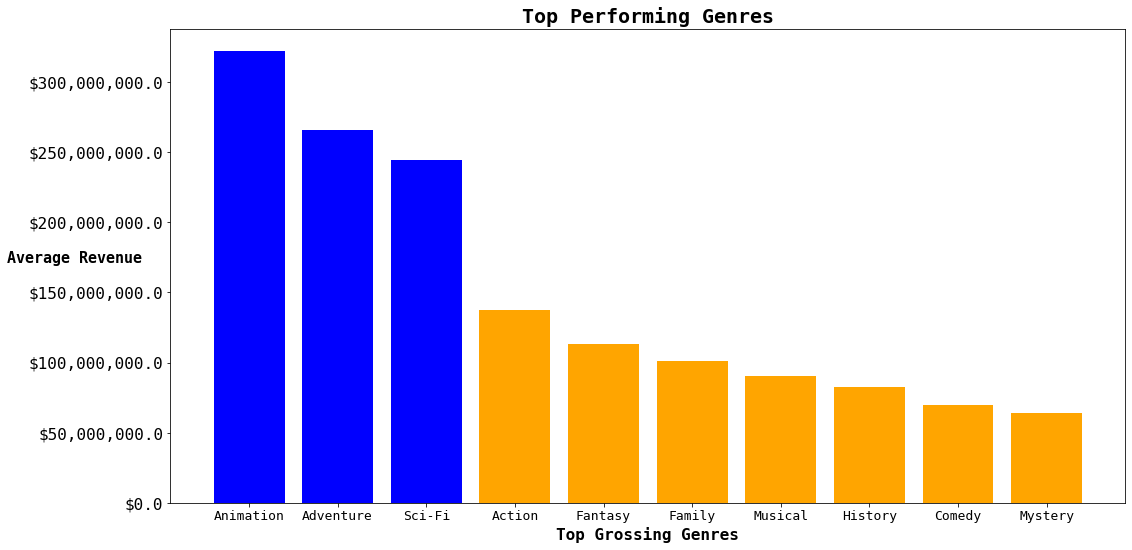

In [14]:
plt.rcParams['font.family'] = 'monospace'

x = genre_gross_df['genres'].head(10)
height= genre_gross_df['worldwide_gross'].head(10)
fig, ax = plt.subplots(figsize=(16,8))


color=['blue', 'blue', 'blue', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']
ax.bar(x=x, height=height, color=color)


plt.title("Top Performing Genres", fontsize=20, loc='center', weight='bold')
ax.set_xlabel('Top Grossing Genres', fontsize=16, weight='bold')

ax.set_ylabel('Average Revenue', fontsize=15, rotation=360, weight='bold', loc='center')
ax.ticklabel_format(style='plain', axis='y')

ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', labelsize=13)

ax.yaxis.set_label_coords(-0.1, 0.5)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))

plt.tight_layout(pad = 2.0)
plt.savefig('images/top_genres.jpg', dpi=400)


In [15]:
top_genres = pd.read_sql('''
SELECT primary_title, movie_id, production_budget, worldwide_gross, month, genres
FROM genres
WHERE genres LIKE '%Adventure%Animation%' or genres LIKE '%Adventure%Sci-FI%'or genres LIKE '%Animation%Sci-FI%' or genres LIKE '%Adventure%Animation%Sci-FI%' 
or genres like '%Adventure%' or genres LIKE '%Animation%' or genres LIKE '%Sci-FI%'
ORDER BY worldwide_gross desc
''', conn)

In [16]:
top_10_full_genres = top_genres.groupby('genres')['worldwide_gross'].median().reset_index()
top_10_full_genres.columns = ['genres', 'median_gross']
top_10_full_genres.sort_values(by='median_gross', ascending=False, inplace=True)

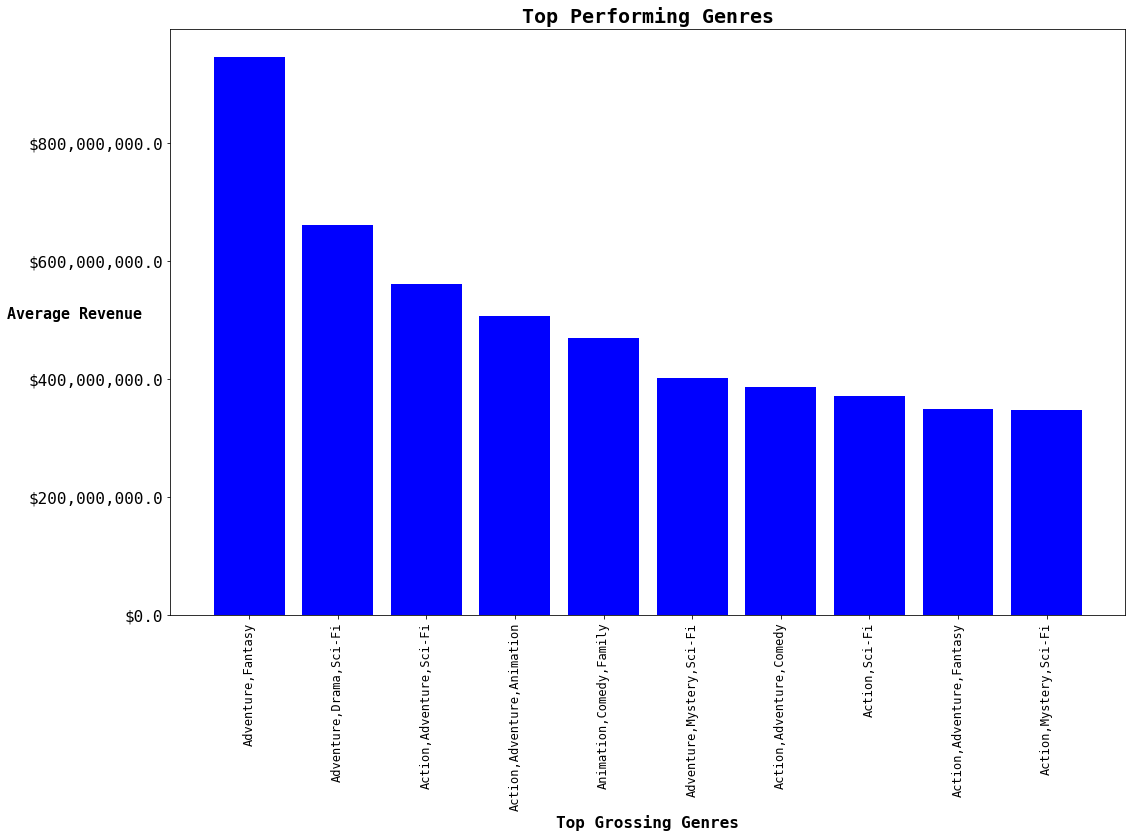

In [17]:
#Plotting the ACTUAL top genres

plt.rcParams['font.family'] = 'monospace'

x = top_10_full_genres['genres'].head(10)
height= top_10_full_genres['median_gross'].head(10)
fig, ax = plt.subplots(figsize=(16,12))



ax.bar(x=x, height=height, color='blue')


plt.title("Top Performing Genres", fontsize=20, loc='center', weight='bold')
ax.set_xlabel('Top Grossing Genres', fontsize=16, weight='bold')

ax.set_ylabel('Average Revenue', fontsize=15, rotation=360, weight='bold', loc='center')
ax.ticklabel_format(style='plain', axis='y')

ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', labelsize=12, rotation = 90)

ax.yaxis.set_label_coords(-0.1, 0.5)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))

plt.tight_layout(pad = 2.0)
plt.savefig('./images/top_genres_combined.jpg', dpi=400)

## Key Takeaways:
- In order to get a better picture of how genre effects worldwide gross I needed to isolate individual genres so that I could apply a central tendancy to the 'worldwide_gross' of each genre and plot the results to show the average best performing genres. 
- The plot shows that Animation, Adventure, and Sci-FI are, on average, the highest performing genres and will typically generate the highest revenue. This does not show the whole picture for genres. To understand the actual highest performing genres we have to look at the genres that have combinations of these three genres.
- So knowing what the top 3 performing genres are I filtered our data set to show the, full genres (movies use multiple genres to define they're move). Doing this I found that the top 3 full genres for worldwide gross revenue is

# Reccomendation Based on Our Combined Insights

In [18]:
full_movies_sql = full_movies_df.to_sql('genres', conn, if_exists='replace', index = False)

In [21]:
recomendation = pd.read_sql('''
SELECT primary_title as title, movie_id, production_budget, worldwide_gross, month, genres
FROM genres
WHERE production_budget >= 65000000
                AND (genres LIKE '%Adventure%Animation%' or genres LIKE '%Adventure%Sci-FI%'
                or genres LIKE '%Animation%Sci-FI%' or genres LIKE '%Adventure%Animation%Sci-FI%')
                AND month >= 5 
                AND month <= 7
                or month == 11
ORDER BY worldwide_gross desc
''', conn)

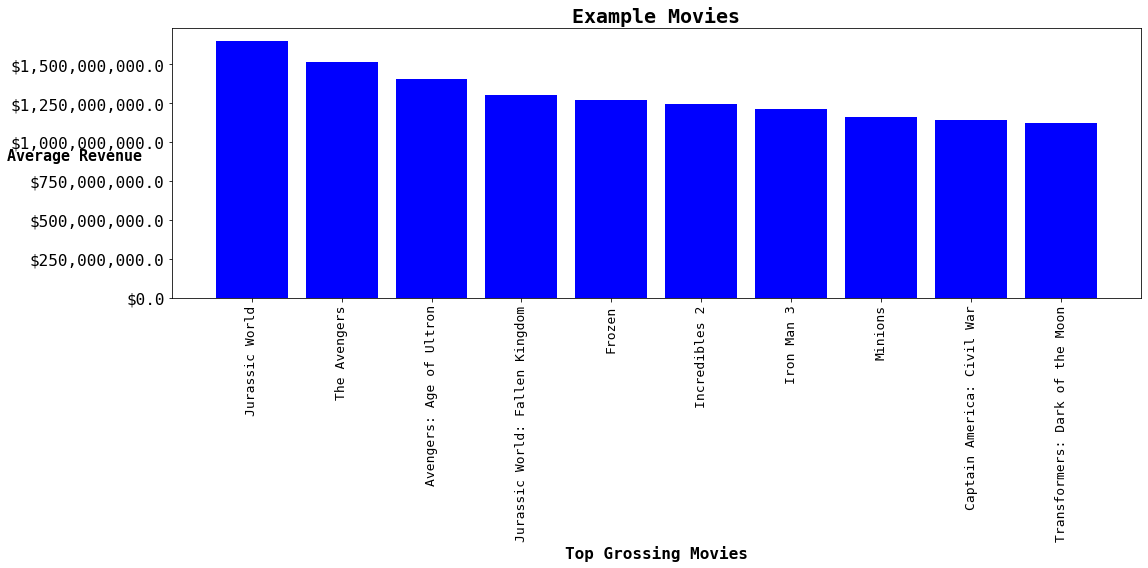

In [22]:
plt.rcParams['font.family'] = 'monospace'

x = recomendation['title'].head(10)
height= recomendation['worldwide_gross'].head(10)
fig, ax = plt.subplots(figsize=(16,8))



ax.bar(x=x, height=height, color= 'blue')


plt.title("Example Movies", fontsize=20, loc='center', weight='bold')
ax.set_xlabel('Top Grossing Movies', fontsize=16, weight='bold')

ax.set_ylabel('Average Revenue', fontsize=15, rotation=360, weight='bold', loc='center')
ax.ticklabel_format(style='plain', axis='y')

ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', labelsize=13, rotation = 90)

ax.yaxis.set_label_coords(-0.1, 0.5)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))

plt.tight_layout()
plt.savefig('./images/example_reccomendations.jpg', dpi=400);